## Modelo SIR en parareal (Julia)

   
\begin{align}
S_{t} & = - \beta S\cdot I  \\
I_{t} & = \beta S \cdot I - \nu I \\
R_{t} & = \nu I 
\end{align}

   
\begin{align}
S_{t} & = - \beta S\cdot I  \\
I_{t} & = \beta S \cdot I - \nu I \\
R(t) & = N - S(t)-I(t)
\end{align}


In [73]:
# Parámetros globales

const global N_ind = 103 # Número de individuos  
const global beta = 0.1
const global nu = 0.9
const global S0 = 100.
const global I0 = 3.

const global t_init = 0.
const global t_end  = 5. 
const global t_n_f = 10000
const global t_n_c = 20

const global N_intervalos = 400;
const global T = LinRange(t_init, t_end, N_intervalos+1)

const global n_iter = 10 # Número de iteraciones de Parareal

#Sistema
const global U0 = [S0 ,I0, N_ind-S0-I0]   # S_0, I_0, R_0

function SIR(U, t)
    S = U[1]
    I = U[2]
    return [-beta*S*I, beta*S*I-nu*I, nu*I]
end

SIR (generic function with 1 method)

## Array de incógintas, $U[i,j,k]$

- Primer índice $i$: subintervalo
- Segundo índice $j$: iteración parareal
- Terecer ínidice $k$: incógnita
    * 1 -> S
    * 2 -> I
    * 3 -> R

## Método de Euler

In [2]:
# Resuelve el sistema de EDO U' = F(U,t), U(0)=U0 en el rango 
# de tiempo T = [t_0, ..., t_n] mediante el método de Euler
function Euler(F, U0, t_init, t_end, n_t)
    dt = (t_end-t_init)/n_t
    t = t_init
    
    #println("n_t=$n_t, t_init=$t_init, t_end=$t_end, dt=$dt")
    U_sol = zeros(size(U0))
    for i=1:n_t
        # Denotamos: U=solución en la etapa actual, U0=sol. etapa anterior
        U_sol = U0 + dt*F(U0, t) # U, U0, F(U,t) arrays numpy

        # Preparamos siguiente iteración
        t += dt
        U0 = U_sol
        
        #println("Iter $i, t=$t, u=$U_sol, ex_sol=$(exp(t))")

    end
    return U_sol
end

Euler (generic function with 1 method)

In [3]:
f1(y,t) = y  # y'=y, y(0)=1, solución exacta: y(t)= e^t
y_end = Euler(f1, 1, t_init, t_end, 10)

println("\nListo. Error en t_end=$t_end: ", exp(t_end) - y_end)


Listo. Error en t_end=5.0: 90.7481200400766


 ## Método Parareal

In [4]:
F(t1, t0, u0) =  Euler(SIR, u0, t0, t1, t_n_f)
G(t1, t0, u0) =  Euler(SIR, u0, t0, t1, t_n_c)

G (generic function with 1 method)

In [64]:
function SIR_secuencial()
    U = Array{Float64,3}(undef, N_intervalos+1, n_iter+1, 3);
    Fn = Array{Float64,2}(undef, N_intervalos+1, 3);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1,:] = U0
    for n=1:N_intervalos
        U[n+1,1,:] = G( T[n+1],T[n],U[n,1,:] )
    end
        
    # 1.b) Inicialización etapas parareal
    for k=1:n_iter
        U[1,k+1,:] = U0
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        @time @inbounds begin
        for n = 1:N_intervalos
            #F_sol[n,:] = F( T[n+1], T[n], U[n,k,:] )
            t0 = T[n]
            t1 = T[n+1]
            Unk = U[n,k,:]
            Fn[n,:] = F( t1, t0, Unk )
        end
        end
        
        # 2.b) Corrección secuencial
        @time @inbounds for n = 1:N_intervalos
            U[n+1, k+1, :] = Fn[n,:] + G( T[n+1], T[n], U[n,k+1,:] ) - G( T[n+1], T[n], U[n,k,:] )
        end
    end
    
    return U
    
end

SIR_secuencial (generic function with 1 method)

In [65]:
function SIR_parareal()
    U = Array{Float64,3}(undef, N_intervalos+1, n_iter+1, 3);
    Fn = Array{Float64,2}(undef, N_intervalos+1, 3);
    Un = Array{Float64,2}(undef, N_intervalos+1, 3);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1,:] = U0
    
    for n=1:N_intervalos
        U[n+1,1,:] = G( T[n+1],T[n],U[n,1,:] )
    end
        
    # 1.b) Inicialización etapas parareal
    @inbounds Threads.@threads for k=1:n_iter
        U[1,k+1,:] = U0
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        @time begin
        @inbounds Threads.@threads for n = 1:N_intervalos
            t0 = T[n]
            t1 = T[n+1]
            #Unk = U[n,k,:]
            Fn[n,:] = F( t1, t0, U[n,k,:] )
        end
        end
        
        # 2.b) Corrección secuencial
        @time @inbounds for n = 1:N_intervalos
            U[n+1, k+1, :] = Fn[n,:] + G( T[n+1], T[n], U[n,k+1,:] ) - G( T[n+1], T[n], U[n,k,:] )
        end

    end
    
    return U
    
end

SIR_parareal (generic function with 1 method)

In [74]:
@time U = SIR_secuencial();

  1.754216 seconds (12.00 M allocations: 1.252 GiB, 15.28% gc time)
  0.007015 seconds (50.80 k allocations: 5.426 MiB)
  1.763031 seconds (12.00 M allocations: 1.252 GiB, 15.71% gc time)
  0.005553 seconds (50.80 k allocations: 5.426 MiB)
  1.747227 seconds (12.00 M allocations: 1.252 GiB, 14.99% gc time)
  0.006972 seconds (50.80 k allocations: 5.426 MiB)
  1.755724 seconds (12.00 M allocations: 1.252 GiB, 15.42% gc time)
  0.004286 seconds (50.80 k allocations: 5.426 MiB)
  1.747275 seconds (12.00 M allocations: 1.252 GiB, 15.06% gc time)
  0.007001 seconds (50.80 k allocations: 5.426 MiB)
  1.748549 seconds (12.00 M allocations: 1.252 GiB, 15.13% gc time)
  0.006977 seconds (50.80 k allocations: 5.426 MiB)
  1.751042 seconds (12.00 M allocations: 1.252 GiB, 15.62% gc time)
  0.007035 seconds (50.80 k allocations: 5.426 MiB)
  1.746109 seconds (12.00 M allocations: 1.252 GiB, 15.15% gc time)
  0.006956 seconds (50.80 k allocations: 5.426 MiB)
  1.752248 seconds (12.00 M allocations:

In [75]:
@time U = SIR_parareal(); 

  1.170610 seconds (12.04 M allocations: 1.254 GiB, 72.21% gc time)
  0.007706 seconds (50.80 k allocations: 5.426 MiB)
  1.933184 seconds (12.00 M allocations: 1.252 GiB, 85.85% gc time)
  0.006978 seconds (50.80 k allocations: 5.426 MiB)
  1.864157 seconds (12.00 M allocations: 1.252 GiB, 85.31% gc time)
  0.007032 seconds (50.80 k allocations: 5.426 MiB)
  2.561700 seconds (12.00 M allocations: 1.252 GiB, 89.44% gc time)
  0.004330 seconds (50.80 k allocations: 5.426 MiB)
  1.672109 seconds (12.00 M allocations: 1.252 GiB, 83.37% gc time)
  0.005059 seconds (50.80 k allocations: 5.426 MiB)
  1.802877 seconds (12.00 M allocations: 1.252 GiB, 85.13% gc time)
  0.007205 seconds (50.80 k allocations: 5.426 MiB)
  1.862626 seconds (12.00 M allocations: 1.252 GiB, 85.67% gc time)
  0.007178 seconds (50.80 k allocations: 5.426 MiB)
  1.764564 seconds (12.00 M allocations: 1.252 GiB, 84.37% gc time)
  0.007028 seconds (50.80 k allocations: 5.426 MiB)
  1.866766 seconds (12.00 M allocations:

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



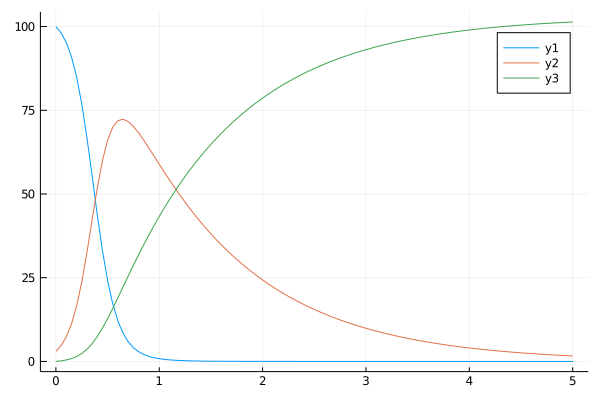

In [9]:
#import Pkg; Pkg.add("Plots")

using Plots

y = U[:,end,:]; # Susceptibles
x = T
plot(x, y)

In [13]:
size(U)

(101, 6, 3)

In [18]:
U1 = zeros(size(U))
copy

UndefVarError: UndefVarError: help not defined

In [14]:
; export HELLOWORLD=3

In [20]:
; echo $SHELL

UndefVarError: UndefVarError: SHELL not defined